# Tabular Models Preparation & Training

## Setup

### Module Imports & Drive Mount

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

from google.colab import userdata
BASE_DATA_DIR = userdata.get('BASE_DATA_DIR')

Mounted at /content/drive/


### Load Preprocessed Data

In [ ]:
preprocessed_dir = os.path.join(BASE_DATA_DIR, 'preprocessed')

X = pd.read_pickle(os.path.join(preprocessed_dir, 'X.pkl'))
y = pd.read_pickle(os.path.join(preprocessed_dir, 'y.pkl'))

print(f"Loaded X: {X.shape}")
print(f"Loaded y: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Survived: {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"  Died: {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")

Loaded X: (203, 28)
Loaded y: (203,)

Target distribution:
  Survived: 106 (52.2%)
  Died: 97 (47.8%)


### Model & Comparison Imports

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import uniform, randint

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
target_col = 'overall survival (death)'

exclude_cols = [
    target_col
]

# Separate features and target
X = high_fill_df.drop(columns=exclude_cols)
y = high_fill_df[target_col]

print("="*60)
print("FEATURES AND TARGET PREPARED")
print("="*60)
print(f"\nFeatures (X): {X.shape[0]} patients × {X.shape[1]} features")
print(f"Target (y):   {len(y)} patients")
print(f"\nTarget distribution:")
print(f"  Alive (0): {(y == 0).sum()} ({(y == 0).sum()/len(y)*100:.1f}%)")
print(f"  Died (1):  {(y == 1).sum()} ({(y == 1).sum()/len(y)*100:.1f}%)")
print(f"\nFeature list ({len(X.columns)} total):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

FEATURES AND TARGET PREPARED

Features (X): 203 patients × 28 features
Target (y):   203 patients

Target distribution:
  Alive (0): 106 (52.2%)
  Died (1):  97 (47.8%)

Feature list (28 total):
   1. sex at birth
   2. race
   3. age at diagnosis
   4. primary diagnosis
   5. grade of primary brain tumor
   6. stereotactic biopsy before surgical resection
   7. progression
   8. time to first progression (days)
   9. type of 1st progression
  10. second progression/recurrence
  11. type of 2nd progression
  12. idh1 mutation
  13. idh2 mutation
  14. 1p/19q
  15. atrx mutation
  16. mgmt methylation
  17. braf v600e mutation
  18. tert promoter mutation
  19. chromosome 7 gain and chromosome 10 loss
  20. h3-3a mutation
  21. egfr amplification
  22. pten mutation
  23. cdkn2a/b deletion
  24. tp53 alteration
  25. previous brain tumor
  26. number of days from diagnosis to first surgery or procedure
  27. number of days from diagnosis to date of first progression
  28. number of days

### MODEL ARCHITECTURE CHOICE: XGBoost


Why XGBoost?

1. Small Dataset (203 patients)
   - XGBoost excels with 100s-10,000s samples
   - Deep learning needs 10,000+ samples
   
2. Heterogenous Features
   - Mix of categorical (sex, race, diagnosis) and numeric (age, days, molecular markers)
   - XGBoost handles mixed types natively
   - No feature scaling required
   
3. Missing Data
   - XGBoost handles NaN values automatically during training
   - No imputation needed for remaining missing values
   
4. Evaluate Feature Importance (Key Goal Here)
   - Built-in feature importance via gain, split count, or SHAP
   - Critical for your two-stage workflow: baseline → feature selection → focused model
   
5. Robust to Overfitting
   - Regularization parameters (lambda, alpha)
   - Max depth limits tree complexity
   - Subsampling provides natural regularization
   
6. Class Balance
   - Your dataset is 52% alive / 48% died (balanced)
   - No special class weighting needed, but XGBoost supports scale_pos_weight if needed
   
7. Proven Performance
   - State-of-the-art for tabular medical data
   - Widely used in clinical ML research
   
Alternatives considered:
- Random Forest: Similar but slightly lower performance than XGBoost
- Logistic Regression: Assumes linear relationships (too simplistic for glioma biology)
- Neural Networks: Need 10x more data, harder to interpret
- LightGBM: Comparable to XGBoost, slightly faster but less tested in medical domain

Decision: XGBoost is optimal for out dataset size, feature types, and with the goal of feature importance extraction in mind.

## Train XGBoost with 5-fold stratified cross-validation

Cast object columns to category dtype

In [ ]:
# XGBoost requires categorical columns to be pandas 'category' dtype, not 'object'
categorical_cols = ['sex at birth', 'race', 'primary diagnosis', 'previous brain tumor']

for col in categorical_cols:
    X[col] = X[col].astype('category')

print("✓ Categorical columns converted to category dtype")
print(f"Updated dtypes: {X[categorical_cols].dtypes.to_dict()}")

✓ Categorical columns converted to category dtype
Updated dtypes: {'sex at birth': CategoricalDtype(categories=['Female', 'Male'], ordered=False, categories_dtype=object), 'race': CategoricalDtype(categories=['Asian', 'Black or African American', 'Unknown', 'White'], ordered=False, categories_dtype=object), 'primary diagnosis': CategoricalDtype(categories=['Astrocytoma', 'Diffuse glioma', 'GBM',
                  'Glioma w/ GBM features', 'Oligodendro-glioma',
                  'Pilocytic astrocytoma'],
, ordered=False, categories_dtype=object), 'previous brain tumor': CategoricalDtype(categories=['No', 'Yes'], ordered=False, categories_dtype=object)}


#### GliomaBinarySurvivalModel() Class & Randomised Search Functions

#### Create GliomaBinarySurvivalModel Class

In [ ]:
class GliomaBinarySurvivalModel:
    def __init__(self, name="Model", params=None, random_state=42, **kwargs):
        """
        name: str
            Model identifier
        params: dict, optional
            Complete parameter dictionary for XGBoost
        random_state: int
            Random seed for reproducibility
        **kwargs: optional
            Individual XGBoost parameters (e.g., max_depth=5, learning_rate=0.05)
        """
        self.name = name
        self.random_state = random_state
        self.model = None
        self.cv_results = None
        self.feature_importance = None
        self.X_train = None  # Store for later reference

        # Default hyperparameters
        default_params = {
            'n_estimators': 150,
            'max_depth': 5,
            'learning_rate': 0.05,
            'subsample': 0.75,
            'colsample_bytree': 1,
            'random_state': random_state,
            'enable_categorical': True,
            'eval_metric': 'logloss'
        }

        # Merge params: defaults <- full params dict <- individual kwargs
        if params is not None:
            default_params.update(params)
        if kwargs:
            default_params.update(kwargs)
        self.params = default_params

    def train_with_cv(self, X, y, cv_folds=5):
        """
        Train with stratified cross-validation
        Parameters:
        X: DataFrame of Features
        y: Series -> Target variable
        cv_folds: int -> Number of cross-validation folds (default: 5)
        """

        self.X_train = X  # Store for feature names
        print(f"\n{'='*70}")
        print(f"Training: {self.name}")
        print(f"{'='*70}")
        print(f"Dataset: {len(X)} patients × {X.shape[1]} features")
        print(f"Target: {(y==0).sum()} alive ({(y==0).sum()/len(y)*100:.1f}%), "
              f"{(y==1).sum()} died ({(y==1).sum()/len(y)*100:.1f}%)")

        # Check class balance
        balance_ratio = min((y==0).sum(), (y==1).sum()) / max((y==0).sum(), (y==1).sum())
        if balance_ratio < 0.3:
            print(f"⚠️  Warning: Imbalanced classes (ratio: {balance_ratio:.2f})")

        # Initialise model & set up CV
        self.model = XGBClassifier(**self.params)
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        scoring = {
            'accuracy': make_scorer(accuracy_score),
            'roc_auc': make_scorer(roc_auc_score),
            'precision': make_scorer(precision_score, zero_division=0),
            'recall': make_scorer(recall_score),
            'f1': make_scorer(f1_score)
        }

        # Cross-validate
        print(f"\nRunning {cv_folds}-fold stratified cross-validation...")
        self.cv_results = cross_validate(
            self.model,
            X,
            y,
            cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1,
            verbose=3
        )

        # Print results
        self._print_cv_results()

        # Train final model on full data
        print("\nTraining final model on full dataset...")
        self.model.fit(X, y)

        # Extract feature importance
        self.feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False).reset_index(drop=True)
        print(f"✓ Model trained successfully\n")

    def _print_cv_results(self):
        """Print formatted CV results"""
        print(f"\n{'Cross-Validation Results':^70}")
        print("-"*70)
        print(f"{'Metric':<15} {'Mean':<12} {'Std Dev':<12} {'Range'}")
        print("-"*70)
        for metric in ['accuracy', 'roc_auc', 'precision', 'recall', 'f1']:
            scores = self.cv_results[f'test_{metric}']
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            min_score = np.min(scores)
            max_score = np.max(scores)
            print(f"{metric.upper():<15} {mean_score:.4f}       ±{std_score:.4f}      "
                  f"[{min_score:.3f}-{max_score:.3f}]")
        print()

    def get_top_features(self, n=None, importance_threshold=None):
        """
        Get top N most important features or features by cumulative importance threshold.

        Parameters:

        n: int, optional
            Number of top features to return (default: None).
        importance_threshold : float, optional
            Cumulative importance threshold (0 to 1) to select features (default: None).
            If provided, 'n' is ignored.

        Returns:

        pd.DataFrame
            Df containing the selected features and their importance.
            Returns None if model is not trained or no valid parameters provided.
        """

        if self.feature_importance is None:
            print("⚠️  Model not trained yet. Run train_with_cv() first.")
            return None

        # If we want threshold importance
        if importance_threshold is not None:
            if not 0 <= importance_threshold <= 1:
                print("⚠️  importance_threshold must be between 0 and 1.")
                return None

            # Calculate cumulative importance & select features up to threshold
            cumulative_importance = self.feature_importance['importance'].cumsum() / self.feature_importance['importance'].sum()
            selected_features = self.feature_importance[cumulative_importance <= importance_threshold]

            return selected_features

        # If we want top n features
        elif n is not None and n > 0:
            return self.feature_importance.head(n)
        else:
            print("⚠️  Please provide either 'n' (number of features) or 'importance_threshold'.")
            return None

    def plot_feature_importance(self, top_n=20, figsize=(12, 10), save_path=None, importance_threshold=None):
        """
        Plot top N most important features or features by cumulative importance threshold.

        Parameters:

        top_n : int, optional
            Number of top features to plot (default: 20). Ignored if importance_threshold is provided.
        figsize : tuple
            Figure size (width, height)
        save_path : str, optional
            Path to save figure (e.g., 'feature_importance.png')
        importance_threshold : float, optional
            Cumulative importance threshold (0 to 1) to select features for plotting (default: None).
        """
        if self.feature_importance is None:
            print("⚠️  Model not trained yet. Run train_with_cv() first.")
            return

        if importance_threshold is not None:
             top_features = self.get_top_features(importance_threshold=importance_threshold)
             title_suffix = f" (Cumulative Importance >= {importance_threshold*100:.0f}%)"
        else:
            top_features = self.get_top_features(n=top_n)
            title_suffix = f" (Top {top_n})"


        if top_features is None or top_features.empty:
             print("⚠️  No features selected based on provided criteria.")
             return

        fig, ax = plt.subplots(figsize=figsize)

        bars = ax.barh(
            range(len(top_features)),
            top_features['importance'].values,
            color=sns.color_palette("viridis", len(top_features)) # Use length of selected features
        )
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'].values, fontsize=10)
        ax.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
        ax.set_title(
            f'Most Important Features\n{self.name} - XGBoost Feature Importance' + title_suffix,
            fontsize=14,
            fontweight='bold'
        )
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)

        # Add value labels
        for i, (idx, row) in enumerate(top_features.iterrows()):
            ax.text(
                row['importance'],
                i,
                f" {row['importance']:.4f}",
                va='center',
                fontsize=9
            )

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Plot saved to {save_path}")

        plt.show()

    def get_performance_summary(self):
        """
        Get performance summary as dictionary

        Returns: dict with model name and performance metrics
        """
        if self.cv_results is None:
            print("⚠️  Model not trained yet. Run train_with_cv() first.")
            return None

        return {
            'name': self.name,
            'n_samples': len(self.cv_results['test_accuracy']) * 5,  # 5-fold CV
            'auc_mean': np.mean(self.cv_results['test_roc_auc']),
            'auc_std': np.std(self.cv_results['test_roc_auc']),
            'accuracy': np.mean(self.cv_results['test_accuracy']),
            'f1': np.mean(self.cv_results['test_f1']),
            'precision': np.mean(self.cv_results['test_precision']),
            'recall': np.mean(self.cv_results['test_recall'])
        }

    def print_summary(self):
        """Print comprehensive model summary"""
        if self.cv_results is None:
            print("⚠️  Model not trained yet.")
            return

        print(f"\n{'='*70}")
        print(f"{self.name} - SUMMARY")
        print(f"{'='*70}")

        summary = self.get_performance_summary()
        print(f"\nPerformance (Cross-Validation):")
        print(f"  AUC-ROC:  {summary['auc_mean']:.4f} ± {summary['auc_std']:.4f}")
        print(f"  Accuracy: {summary['accuracy']:.4f}")
        print(f"  F1-Score: {summary['f1']:.4f}")
        print(f"  Precision: {summary['precision']:.4f}")
        print(f"  Recall:   {summary['recall']:.4f}")

        print(f"\nTop 5 Features:")

        # Call get_top_features with n=5 for the summary print
        top_5_features = self.get_top_features(n=5)
        if top_5_features is not None:
            for i, row in top_5_features.iterrows():
                print(f"  {i+1}. {row['feature']:<45} {row['importance']:.6f}")

        print(f"\nHyperparameters:")
        for key, value in self.params.items():
            if key != 'random_state':
                print(f"  {key}: {value}")

Usage examples of the class

In [ ]:
# # Usage Examples:
# # Example 1: Use defaults
# model1 = GliomaBinarySurvivalModel(name="Baseline Model")
# model1.train_with_cv(X, y)
# model1.plot_feature_importance(top_n=15)

# # Example 2: Pass individual params
# model2 = GliomaBinarySurvivalModel(
#     name="Deep Trees Model",
#     max_depth=6,
#     learning_rate=0.05,
#     n_estimators=200
# )
# model2.train_with_cv(X, y)

# # Example 3: Pass full params dict
# custom_params = {
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'n_estimators': 150,
#     'subsample': 0.7
# }
# model3 = GliomaBinarySurvivalModel(name="Custom Model", params=custom_params)
# model3.train_with_cv(X, y)

# # Compare all models
# all_models = [model1, model2, model3]
# comparison_df = compare_models(all_models)
# print(comparison_df)

# # Print detailed summary
# model1.print_summary()

##### Compare instances of GliomaBinarySurvivalModel models

In [ ]:
def compare_models(models, figsize=(12, 6)):
    """
    Compare performance across multiple models

    Parameters:
    models : list of GliomaSurvivalModel
        List of trained models to compare
    figsize : tuple
        Figure size
    """
    summaries = [m.get_performance_summary() for m in models]
    comparison_df = pd.DataFrame(summaries)

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # AUC comparison
    axes[0].barh(
        comparison_df['name'],
        comparison_df['auc_mean'],
        xerr=comparison_df['auc_std'],
        color=sns.color_palette("Set2", len(models))
    )
    axes[0].set_xlabel('AUC-ROC', fontweight='bold')
    axes[0].set_title('Model Performance Comparison\n(AUC-ROC)', fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

    # Multiple metrics comparison
    metrics_df = comparison_df[['name', 'accuracy', 'f1', 'precision', 'recall']].set_index('name')
    metrics_df.plot(
        kind='barh',
        ax=axes[1],
        color=sns.color_palette("Set3", 4)
    )
    axes[1].set_xlabel('Score', fontweight='bold')
    axes[1].set_title('Multiple Metrics Comparison', fontweight='bold')
    axes[1].legend(loc='lower right', fontsize=9)
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return comparison_df

##### Randomised Hyperparameter Search Function

In [ ]:
def hyperparameter_search(X, y, param_distributions=None, n_iter=100,
                         cv_folds=5, scoring='roc_auc', random_state=42,
                         plot_results=True, figsize=(14, 5)):
    """
    Perform randomised hyperparameter search for XGBoost binary classification.

    Parameters:
    X: DataFrame
        Feature matrix
    y: Series
        Target variable (binary)
    param_distributions: dict, optional
        Parameter search space. If None, uses sensible defaults.
    n_iter: int
        Number of random combinations to try (default: 100)
    cv_folds: int
        Number of cross-validation folds (default: 5)
    scoring: str
        Metric to optimise (default: 'roc_auc')
    random_state: int
        Random seed for reproducibility
    plot_results: bool
        Whether to plot search results (default: True)
    figsize: tuple
        Figure size for plots (default: (14, 5))

    Returns:
    random_search: RandomizedSearchCV object
        Fitted search object containing best_params_, best_score_, cv_results_
    """

    print("="*70)
    print("HYPERPARAMETER SEARCH")
    print("="*70)
    print(f"Dataset: {len(X)} patients × {X.shape[1]} features")
    print(f"Target: {(y==0).sum()} alive ({(y==0).sum()/len(y)*100:.1f}%), "
          f"{(y==1).sum()} died ({(y==1).sum()/len(y)*100:.1f}%)")

    # Check class balance
    balance_ratio = min((y==0).sum(), (y==1).sum()) / max((y==0).sum(), (y==1).sum())
    if balance_ratio < 0.3:
        print(f"⚠️  Warning: Imbalanced classes (ratio: {balance_ratio:.2f})")

    # Default parameter search space
    if param_distributions is None:
        param_distributions = {
            'n_estimators': randint(110, 220),
            'max_depth': randint(4, 7),
            'learning_rate': uniform(0.03, 0.2),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 0.5),
            'subsample': uniform(0.7, 0.3),
            'colsample_bytree': uniform(0.75, 0.25),
            'reg_alpha': uniform(0, 0.2),
            'reg_lambda': uniform(0, 2),
        }

    # Base model
    base_model = XGBClassifier(
        random_state=random_state,
        enable_categorical=True,
        eval_metric='logloss',
        tree_method='hist',
        n_jobs=-1
    )

    # Cross-validation strategy
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    # Run RandomizedSearch
    print(f"\nSearching {n_iter} random configurations with {cv_folds}-fold CV...")
    print(f"Optimising for: {scoring.upper()}")

    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1,
        return_train_score=True,
        refit=True
    )

    random_search.fit(X, y)

    # Print results
    print("\n" + "="*70)
    print("SEARCH COMPLETE")
    print("="*70)
    print(f"\nBest {scoring.upper()}: {random_search.best_score_:.4f}")

    print("\nBest Hyperparameters:")
    print("-"*70)
    for param, value in sorted(random_search.best_params_.items()):
        if isinstance(value, float):
            print(f"  {param:<25} {value:.4f}")
        else:
            print(f"  {param:<25} {value}")

    # Check overfitting
    results_df = pd.DataFrame(random_search.cv_results_)
    best_idx = random_search.best_index_
    train_score = results_df.loc[best_idx, 'mean_train_score']
    val_score = random_search.best_score_
    overfit_gap = train_score - val_score

    print(f"\nOverfitting Check:")
    print(f"  Train score:   {train_score:.4f}")
    print(f"  Val score:     {val_score:.4f}")
    print(f"  Train-Val gap: {overfit_gap:.4f}", end="")

    if overfit_gap > 0.1:
        print(" ⚠️  (High overfitting)")
    elif overfit_gap > 0.05:
        print(" ⚠️  (Moderate overfitting)")
    else:
        print(" ✓ (Good generalisation)")

    print("\n" + "="*70 + "\n")

    # Plot results
    if plot_results:
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Plot 1: Search convergence
        ax1 = axes[0]
        results_sorted = results_df.sort_values('rank_test_score')
        ax1.plot(range(len(results_sorted)), results_sorted['mean_test_score'],
                'o-', alpha=0.6, markersize=4, color='steelblue')
        ax1.axhline(y=random_search.best_score_, color='red', linestyle='--',
                   label=f'Best: {random_search.best_score_:.4f}', linewidth=2)
        ax1.set_xlabel('Ranked Configuration', fontsize=11, fontweight='bold')
        ax1.set_ylabel(f'{scoring.upper()} Score', fontsize=11, fontweight='bold')
        ax1.set_title('Hyperparameter Search Convergence', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # Plot 2: Train vs Validation
        ax2 = axes[1]
        top_50 = results_df.nsmallest(50, 'rank_test_score')
        scatter = ax2.scatter(top_50['mean_train_score'],
                             top_50['mean_test_score'],
                             alpha=0.6, s=50,
                             c=top_50['mean_test_score'],
                             cmap='RdYlGn', edgecolors='black', linewidth=0.5)

        # Perfect fit line
        lims = [0.5, 1.0]
        ax2.plot(lims, lims, 'k--', alpha=0.4, zorder=0, label='Perfect fit (no overfitting)')
        ax2.set_xlabel('Train Score', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Validation Score', fontsize=11, fontweight='bold')
        ax2.set_title('Train vs Validation Performance (Top 50)', fontsize=12, fontweight='bold')
        ax2.legend(loc='lower right')
        ax2.grid(alpha=0.3)
        plt.colorbar(scatter, ax=ax2, label='Val Score')

        plt.tight_layout()
        plt.savefig('hyperparameter_search_results.png', dpi=300, bbox_inches='tight')
        print("✓ Search visualisation saved to 'hyperparameter_search_results.png'\n")
        plt.show()

    return random_search

##### Function to train model

In [ ]:
def train_best_model(random_search, X, y, model_name="Optimised Model",
                     cv_folds=5, plot_top_n=20, importance_threshold=None,
                     save_plots=True):
    """
    Train a GliomaBinarySurvivalModel with optimised hyperparameters from search.

    Parameters:
    random_search: RandomizedSearchCV object
        Fitted search object from hyperparameter_search()
    X: DataFrame
        Feature matrix
    y: Series
        Target variable (binary)
    model_name: str
        Name for the model (default: "Optimised Model")
    cv_folds: int
        Number of cross-validation folds (default: 5)
    plot_top_n: int
        Number of top features to plot (default: 20). Ignored if importance_threshold provided.
    importance_threshold: float, optional
        Cumulative importance threshold (0-1) for feature plotting (default: None)
    save_plots: bool
        Whether to save plots to disk (default: True)

    Returns:
    model: GliomaBinarySurvivalModel
        Trained model object with all results stored
    """

    print("="*70)
    print("TRAINING FINAL MODEL WITH OPTIMISED HYPERPARAMETERS")
    print("="*70)

    # Extract best parameters
    best_params = random_search.best_params_

    # Instantiate class with optimised parameters
    model = GliomaBinarySurvivalModel(
        name=model_name,
        params=best_params,
        random_state=best_params.get('random_state', 42)
    )

    # Train & output results
    model.train_with_cv(X, y, cv_folds=cv_folds)
    model.print_summary()

    # Plot feature importance
    plot_path = 'feature_importance_optimised.png' if save_plots else None

    if importance_threshold is not None:
        model.plot_feature_importance(
            importance_threshold=importance_threshold,
            figsize=(12, 10),
            save_path=plot_path
        )
    else:
        model.plot_feature_importance(
            top_n=plot_top_n,
            figsize=(12, 10),
            save_path=plot_path
        )

    print("\n" + "="*70)
    print("FINAL MODEL READY")
    print("="*70)

    # Get performance summary
    performance = model.get_performance_summary()
    print(f"Model name: {performance['name']}")
    print(f"Trained on: {performance['n_samples']} samples")
    print(f"ROC-AUC: {performance['auc_mean']:.4f} ± {performance['auc_std']:.4f}")
    print("="*70 + "\n")

    return model

##### Wrapper function for hyperparameter search & training best model

In [ ]:
def hyperparameter_search_and_train(X, y, param_distributions=None, n_iter=100,
                                   cv_folds=5, scoring='roc_auc', random_state=42,
                                   model_name="Optimised Model", plot_top_n=20,
                                   importance_threshold=None, save_plots=True,
                                   plot_search=True):
    """
    Convenience wrapper that calls hyperparameter_search() and train_best_model().

    Parameters:
    X: DataFrame
        Feature matrix
    y: Series
        Target variable (binary)
    param_distributions: dict, optional
        Parameter search space. If None, uses sensible defaults.
    n_iter: int
        Number of random combinations to try (default: 100)
    cv_folds: int
        Number of cross-validation folds (default: 5)
    scoring: str
        Metric to optimise (default: 'roc_auc')
    random_state: int
        Random seed for reproducibility
    model_name: str
        Name for the final model (default: "Optimised Model")
    plot_top_n: int
        Number of top features to plot (default: 20). Ignored if importance_threshold provided.
    importance_threshold  float, optional
        Cumulative importance threshold (0-1) for feature plotting (default: None)
    save_plots: bool
        Whether to save plots to disk (default: True)
    plot_search: bool
        Whether to plot search results (default: True)

    Returns:
    model: GliomaBinarySurvivalModel
        Trained model with optimised hyperparameters
    random_search: RandomizedSearchCV
        Search object with all search results
    """

    print("\n" + "🚀"*35)
    print("COMPLETE MODEL OPTIMISATION PIPELINE")
    print("🚀"*35 + "\n")

    # Hyperparameter search
    random_search = hyperparameter_search(
        X=X,
        y=y,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv_folds=cv_folds,
        scoring=scoring,
        random_state=random_state,
        plot_results=plot_search,
        figsize=(14, 5)
    )

    # Train best model
    model = train_best_model(
        random_search=random_search,
        X=X,
        y=y,
        model_name=model_name,
        cv_folds=cv_folds,
        plot_top_n=plot_top_n,
        importance_threshold=importance_threshold,
        save_plots=save_plots
    )

    print("\n" + "✅"*35)
    print("PIPELINE COMPLETE!")
    print("✅"*35)
    print("\nGenerated outputs:")
    if plot_search:
        print("  📊 hyperparameter_search_results.png")
    if save_plots:
        print("  📊 feature_importance_optimised.png")
    print("\nReturned objects:")
    print("  - model: Trained GliomaBinarySurvivalModel instance")
    print("  - random_search: RandomizedSearchCV results\n")

    return model, random_search

Usage examples

In [ ]:
# # Train with cumulative importance threshold instead of top_n
# model = train_best_model(
#     search,
#     X,
#     y,
#     importance_threshold=0.8,  # Features explaining 80% of decisions
#     model_name="My Model"
# )

# # Or in one-liner
# model, search = hyperparameter_search_and_train(
#     X, y,
#     importance_threshold=0.8,
#     n_iter=100
# )

#### Actual Implementation & Training


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
COMPLETE MODEL OPTIMISATION PIPELINE
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

HYPERPARAMETER SEARCH
Dataset: 203 patients × 28 features
Target: 106 alive (52.2%), 97 died (47.8%)

Searching 100 random configurations with 5-fold CV...
Optimising for: ROC_AUC
Fitting 5 folds for each of 100 candidates, totalling 500 fits

SEARCH COMPLETE

Best ROC_AUC: 0.7770

Best Hyperparameters:
----------------------------------------------------------------------
  colsample_bytree          0.8824
  gamma                     0.1209
  learning_rate             0.0486
  max_depth                 4
  min_child_weight          5
  n_estimators              141
  reg_alpha                 0.1266
  reg_lambda                0.6781
  subsample                 0.8048

Overfitting Check:
  Train score:   0.9336
  Val score:     0.7770
  Train-Val gap: 0.1566 ⚠️  (High overfitting)


✓ Search visualisation saved to 'hyperparameter_search_results.png'



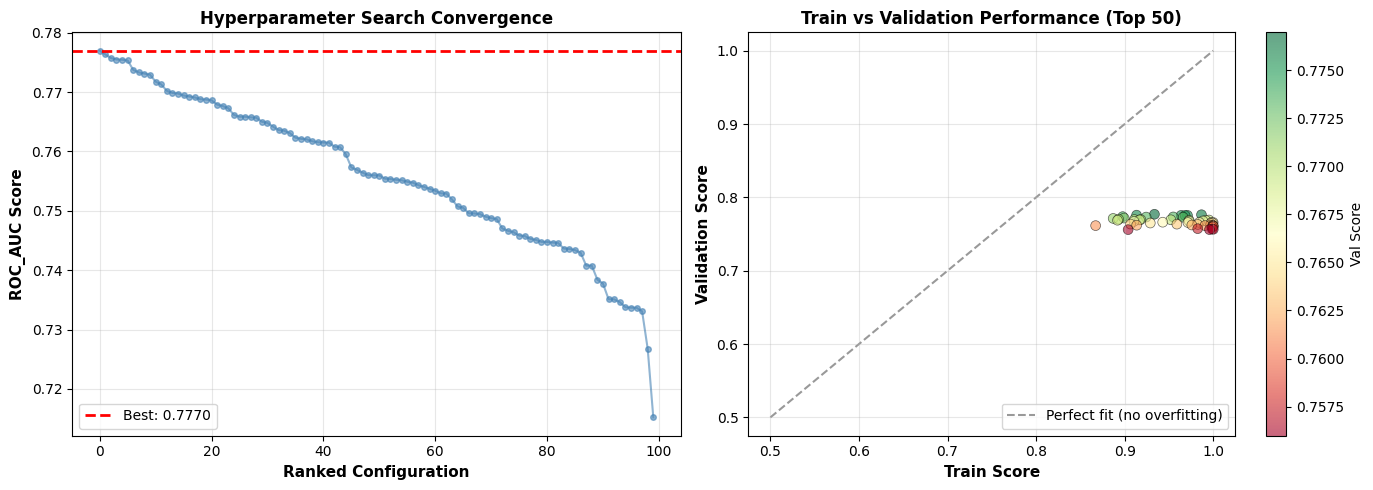

TRAINING FINAL MODEL WITH OPTIMISED HYPERPARAMETERS

Training: Optimised Model
Dataset: 203 patients × 28 features
Target: 106 alive (52.2%), 97 died (47.8%)

Running 5-fold stratified cross-validation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished



                       Cross-Validation Results                       
----------------------------------------------------------------------
Metric          Mean         Std Dev      Range
----------------------------------------------------------------------
ACCURACY        0.7290       ±0.0916      [0.585-0.854]
ROC_AUC         0.7298       ±0.0907      [0.587-0.854]
PRECISION       0.7077       ±0.0983      [0.565-0.850]
RECALL          0.7526       ±0.0661      [0.650-0.850]
F1              0.7287       ±0.0823      [0.605-0.850]


Training final model on full dataset...
✓ Model trained successfully


Optimised Model - SUMMARY

Performance (Cross-Validation):
  AUC-ROC:  0.7298 ± 0.0907
  Accuracy: 0.7290
  F1-Score: 0.7287
  Precision: 0.7077
  Recall:   0.7526

Top 5 Features:
  1. idh1 mutation                                 0.305141
  2. primary diagnosis                             0.120918
  3. age at diagnosis                              0.080198
  4. second progression/

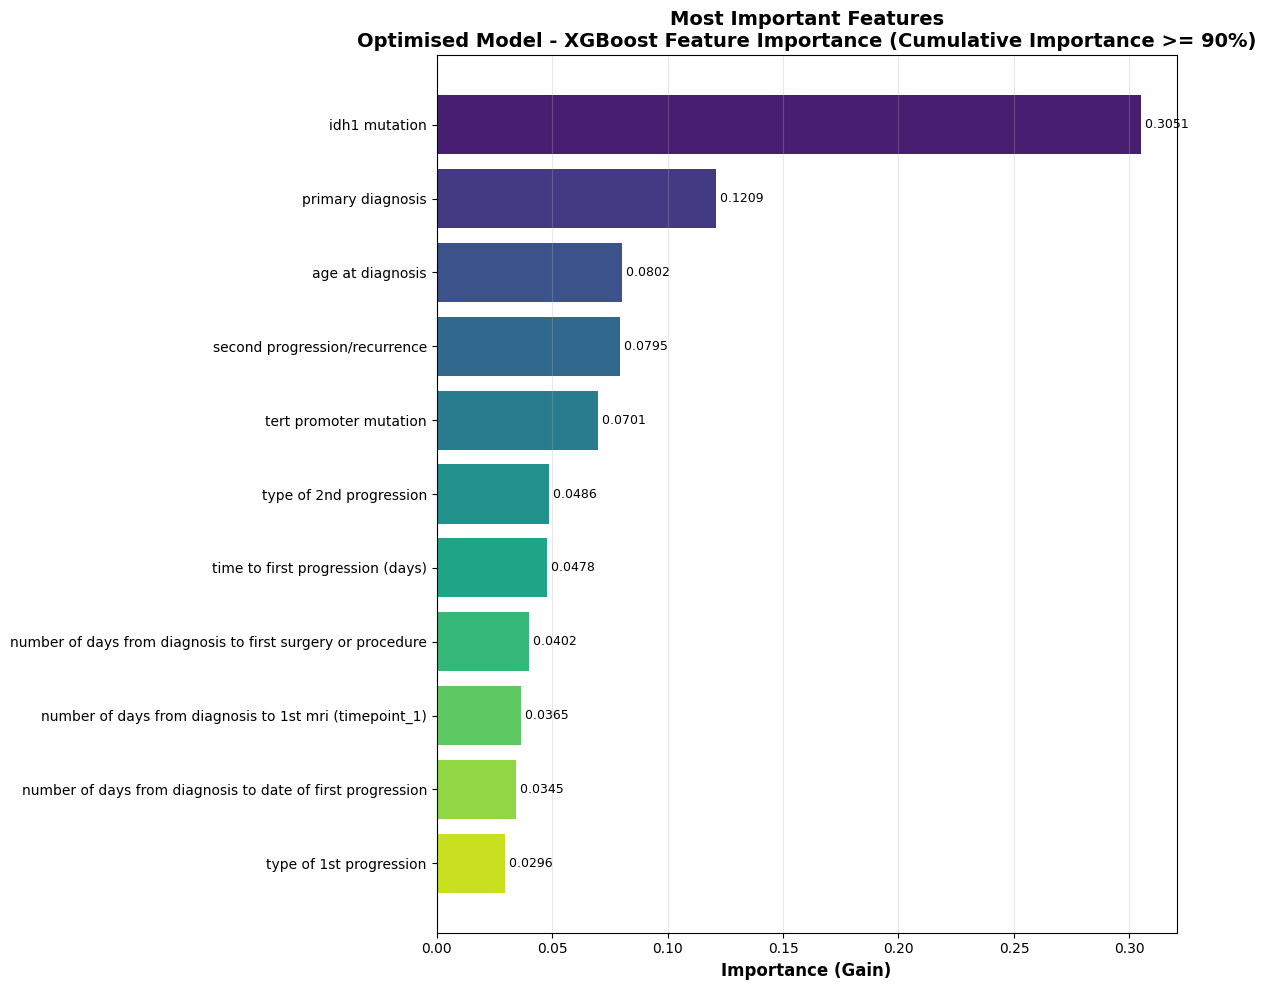


FINAL MODEL READY
Model name: Optimised Model
Trained on: 25 samples
ROC-AUC: 0.7298 ± 0.0907


✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
PIPELINE COMPLETE!
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅

Generated outputs:
  📊 hyperparameter_search_results.png
  📊 feature_importance_optimised.png

Returned objects:
  - model: Trained GliomaBinarySurvivalModel instance
  - random_search: RandomizedSearchCV results



In [ ]:
model, search = hyperparameter_search_and_train(
    X, y,
    importance_threshold=0.9,
    n_iter=100
)

## Data Leakage Detection

The baseline model shows signs of overfitting. We check for data leakage by examining feature-target correlations. Features with suspiciously high correlations may represent future information that wouldn't be available at prediction time.

### Encode Categorical Features for Correlation Analysis

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
label_encoders = {}

for col in X_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

print(f"Encoded {len(label_encoders)} categorical columns for correlation analysis")

Encoded 4 categorical columns for correlation analysis


### Feature-Target Correlation

In [ ]:
feature_target_corr = X_encoded.corrwith(y).sort_values(ascending=False)

print("Feature-Target Correlation (sorted by correlation with death)")
print("-"*71)
print(feature_target_corr.to_string())

# Flag suspicious features (|correlation| > 0.25)
threshold = 0.25
suspicious_features = feature_target_corr[abs(feature_target_corr) > threshold].index.tolist()

print(f"\nSuspicious features (|r| > {threshold}): {len(suspicious_features)}")
for f in suspicious_features:
    print(f"  - {f}: {feature_target_corr[f]:.3f}")

Feature-Target Correlation (sorted by correlation with death)
-----------------------------------------------------------------------
age at diagnosis                                               0.334530
second progression/recurrence                                  0.318335
grade of primary brain tumor                                   0.283698
type of 2nd progression                                        0.249142
primary diagnosis                                              0.213954
progression                                                    0.167566
number of days from diagnosis to first surgery or procedure    0.165322
braf v600e mutation                                            0.159967
sex at birth                                                   0.142928
tert promoter mutation                                         0.135791
h3-3a mutation                                                 0.125246
egfr amplification                                             0.112238
ch

### Feature-Feature Correlation for Suspicious Features

In [ ]:
if suspicious_features:
    print("Correlation matrix for suspicious features:")
    suspicious_corr = X_encoded[suspicious_features].corr()
    print(suspicious_corr.to_string())

Correlation matrix for suspicious features:
                               age at diagnosis  second progression/recurrence  grade of primary brain tumor  idh1 mutation  idh2 mutation
age at diagnosis                       1.000000                      -0.054454                      0.450825      -0.516191      -0.515133
second progression/recurrence         -0.054454                       1.000000                      0.137051      -0.164538      -0.154604
grade of primary brain tumor           0.450825                       0.137051                      1.000000      -0.534069      -0.621112
idh1 mutation                         -0.516191                      -0.164538                     -0.534069       1.000000       0.864395
idh2 mutation                         -0.515133                      -0.154604                     -0.621112       0.864395       1.000000


### Visualise Correlations

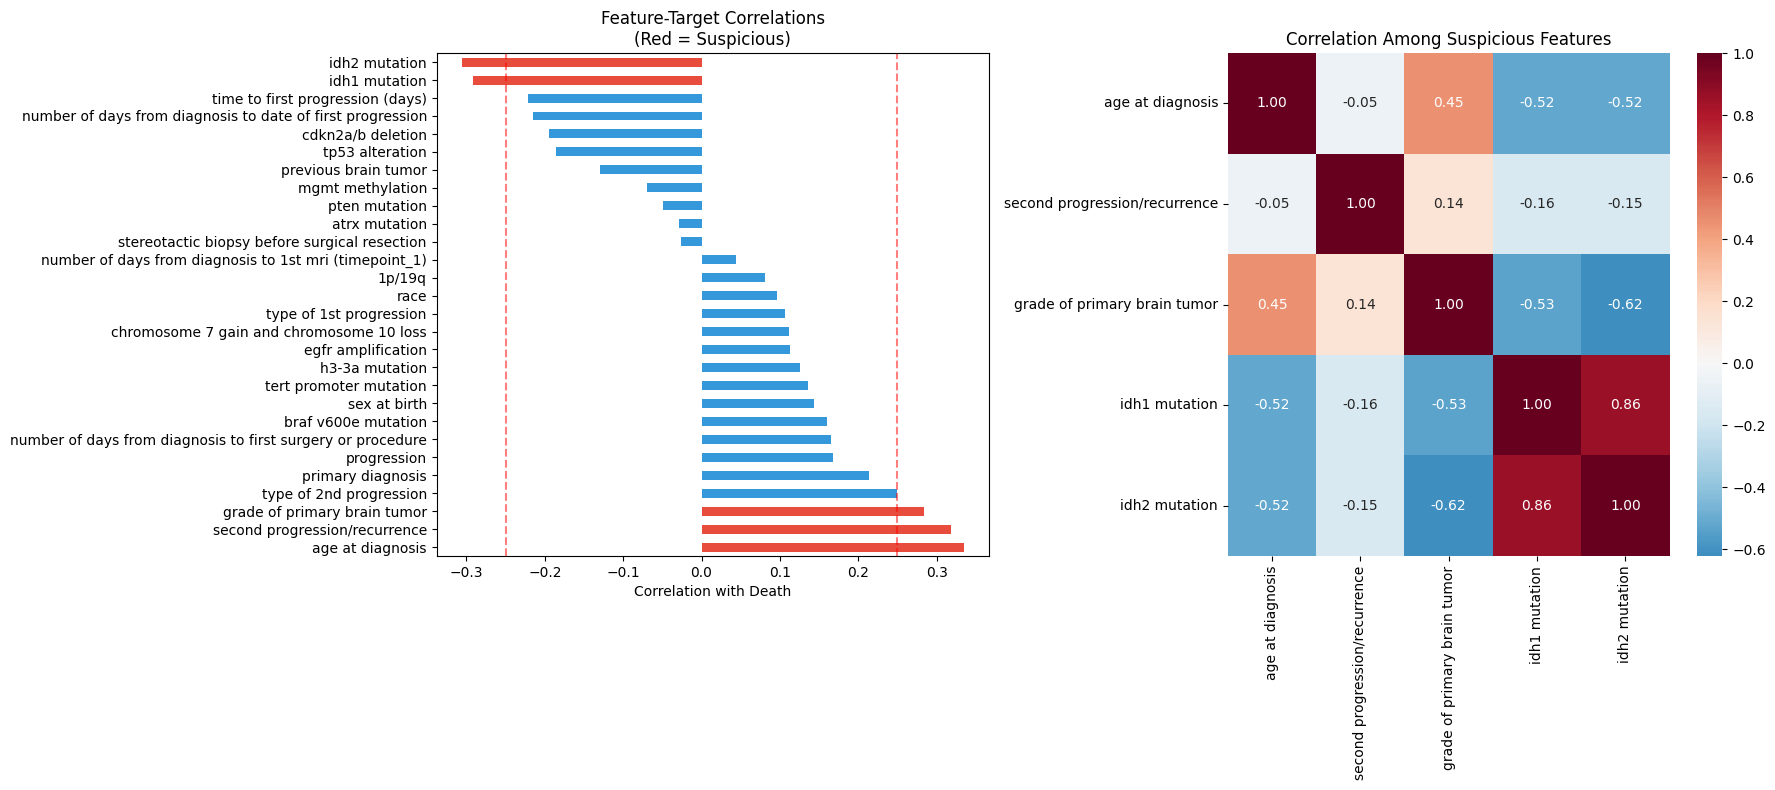

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Feature-Target Correlations
ax1 = axes[0]
colors = ['#e74c3c' if abs(v) > threshold else '#3498db' for v in feature_target_corr.values]
feature_target_corr.plot(kind='barh', ax=ax1, color=colors)
ax1.axvline(x=threshold, color='red', linestyle='--', alpha=0.5)
ax1.axvline(x=-threshold, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Correlation with Death')
ax1.set_title('Feature-Target Correlations\n(Red = Suspicious)')

# Plot 2: Heatmap of suspicious features
ax2 = axes[1]
if suspicious_features:
    sns.heatmap(X_encoded[suspicious_features].corr(), annot=True, cmap='RdBu_r',
                center=0, fmt='.2f', ax=ax2)
    ax2.set_title('Correlation Among Suspicious Features')
else:
    ax2.text(0.5, 0.5, 'No suspicious features found', ha='center', va='center')

plt.tight_layout()
plt.show()

### Identify Leakage Clusters

In [ ]:
if len(suspicious_features) > 0:
    print("Leakage Cluster Analysis")
    print("-"*60)

    # Find highly correlated pairs
    corr_matrix = X_encoded[suspicious_features].corr()
    high_corr_pairs = []

    for idx, feat1 in enumerate(suspicious_features):
        for feat2 in suspicious_features[idx+1:]:
            corr_val = corr_matrix.loc[feat1, feat2]
            if abs(corr_val) > 0.5:
                high_corr_pairs.append((feat1, feat2, corr_val))

    if high_corr_pairs:
        print("\nHighly correlated suspicious feature pairs (|r| > 0.5):")
        for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {f1} <-> {f2}: {corr:.3f}")

Leakage Cluster Analysis
------------------------------------------------------------

Highly correlated suspicious feature pairs (|r| > 0.5):
  idh1 mutation <-> idh2 mutation: 0.864
  grade of primary brain tumor <-> idh2 mutation: -0.621
  grade of primary brain tumor <-> idh1 mutation: -0.534
  age at diagnosis <-> idh1 mutation: -0.516
  age at diagnosis <-> idh2 mutation: -0.515


### Analysis

The correlation analysis reveals two types of high-correlation features:

**Legitimate (biological):** IDH mutations, age, grade, and primary diagnosis cluster together because they reflect known glioma biology.

**Leakage (temporal):** Progression-related features correlate with death because they measure outcomes that occur *after* the prediction timepoint. These must be removed.

## Train Clean Model Without Leakage Features

The 0.25 correlation threshold we set identifies statistically suspicious features but misses some temporal leakage (e.g., progression has r=0.15 but is definitionally future information at time of diagnosis).

As a general rule, leaky features can be identified by answering "Yes" to the following question: "Was this feature known at the time of prediction (diagnosis), or was it measured afterwards?".
In other words, leakage is determined by temporal logic, therefore the final leakage list is defined by whether the feature was available at diagnosis, not by correlation strength alone.

Our leakage analysis identified 7 features that measure **future outcomes** rather than baseline characteristics. We remove these features from X but keep all patients.

In [ ]:
leakage_features = [
    'second progression/recurrence',
    'type of 2nd progression',
    'time to first progression (days)',
    'number of days from diagnosis to date of first progression',
    'number of days from diagnosis to first surgery or procedure',
    'progression',
    'type of 1st progression'
]

X_clean = X.drop(columns=leakage_features, errors='ignore').copy()

In [ ]:
print(f"Removed {len(leakage_features)} leakage features:")
for f in leakage_features:
    print(f"  - {f}")

print(f"\nRemaining {X_clean.shape[1]} features:")
for f in X_clean.columns:
    print(f"  - {f}")

Removed 7 leakage features:
  - second progression/recurrence
  - type of 2nd progression
  - time to first progression (days)
  - number of days from diagnosis to date of first progression
  - number of days from diagnosis to first surgery or procedure
  - progression
  - type of 1st progression

Remaining 21 features:
  - sex at birth
  - race
  - age at diagnosis
  - primary diagnosis
  - grade of primary brain tumor
  - stereotactic biopsy before surgical resection
  - idh1 mutation
  - idh2 mutation
  - 1p/19q
  - atrx mutation
  - mgmt methylation
  - braf v600e mutation
  - tert promoter mutation
  - chromosome 7 gain and chromosome 10 loss
  - h3-3a mutation
  - egfr amplification
  - pten mutation
  - cdkn2a/b deletion
  - tp53 alteration
  - previous brain tumor
  - number of days from diagnosis to 1st mri (timepoint_1)


In [ ]:
y_clean = y.copy()

print(f"X_clean shape: {X_clean.shape}")
print(f"y_clean shape: {y_clean.shape}")
print(f"\nTarget distribution:")
print(f"  Survived: {(y_clean == 0).sum()} ({(y_clean == 0).mean()*100:.1f}%)")
print(f"  Died: {(y_clean == 1).sum()} ({(y_clean == 1).mean()*100:.1f}%)")

X_clean shape: (203, 21)
y_clean shape: (203,)

Target distribution:
  Survived: 106 (52.2%)
  Died: 97 (47.8%)


### Train Clean Model


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
COMPLETE MODEL OPTIMISATION PIPELINE
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

HYPERPARAMETER SEARCH
Dataset: 203 patients × 21 features
Target: 106 alive (52.2%), 97 died (47.8%)

Searching 100 random configurations with 5-fold CV...
Optimising for: ROC_AUC
Fitting 5 folds for each of 100 candidates, totalling 500 fits

SEARCH COMPLETE

Best ROC_AUC: 0.7248

Best Hyperparameters:
----------------------------------------------------------------------
  colsample_bytree          0.7844
  gamma                     0.1705
  learning_rate             0.0527
  max_depth                 6
  min_child_weight          3
  n_estimators              116
  reg_alpha                 0.1320
  reg_lambda                1.6344
  subsample                 0.8666

Overfitting Check:
  Train score:   0.9417
  Val score:     0.7248
  Train-Val gap: 0.2169 ⚠️  (High overfitting)


✓ Search visualisation saved to 'hyperparameter_search_results.png'



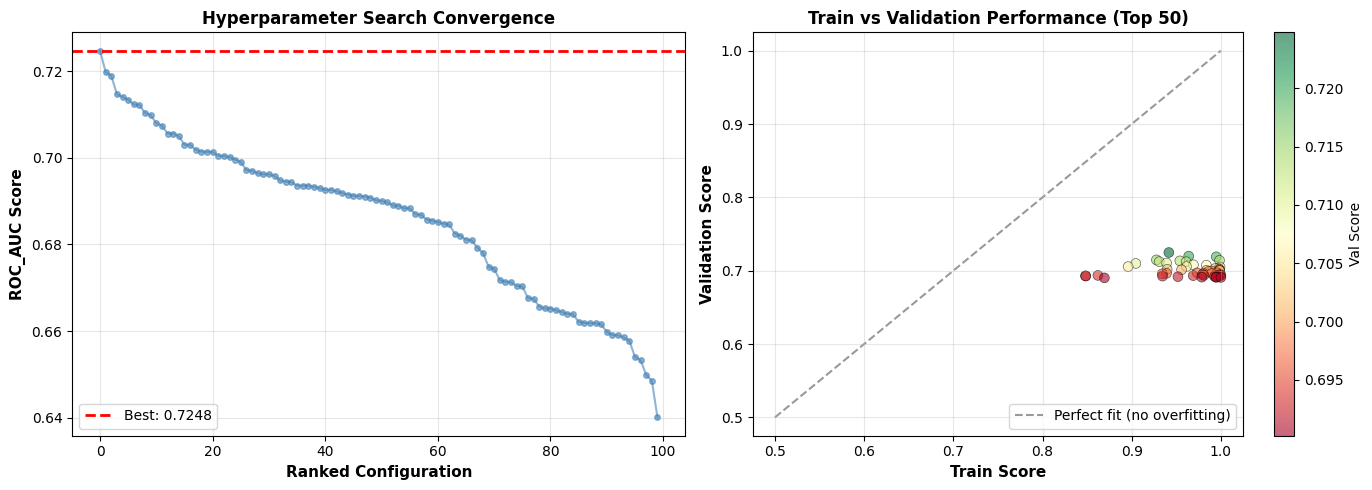

TRAINING FINAL MODEL WITH OPTIMISED HYPERPARAMETERS

Training: Clean Model (No Leakage)
Dataset: 203 patients × 21 features
Target: 106 alive (52.2%), 97 died (47.8%)

Running 5-fold stratified cross-validation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished



                       Cross-Validation Results                       
----------------------------------------------------------------------
Metric          Mean         Std Dev      Range
----------------------------------------------------------------------
ACCURACY        0.6698       ±0.1133      [0.537-0.829]
ROC_AUC         0.6735       ±0.1113      [0.538-0.829]
PRECISION       0.6443       ±0.1227      [0.519-0.842]
RECALL          0.7432       ±0.0749      [0.600-0.800]
F1              0.6870       ±0.0945      [0.558-0.821]


Training final model on full dataset...
✓ Model trained successfully


Clean Model (No Leakage) - SUMMARY

Performance (Cross-Validation):
  AUC-ROC:  0.6735 ± 0.1113
  Accuracy: 0.6698
  F1-Score: 0.6870
  Precision: 0.6443
  Recall:   0.7432

Top 5 Features:
  1. idh1 mutation                                 0.193641
  2. primary diagnosis                             0.192767
  3. tert promoter mutation                        0.139878
  4. chromosome

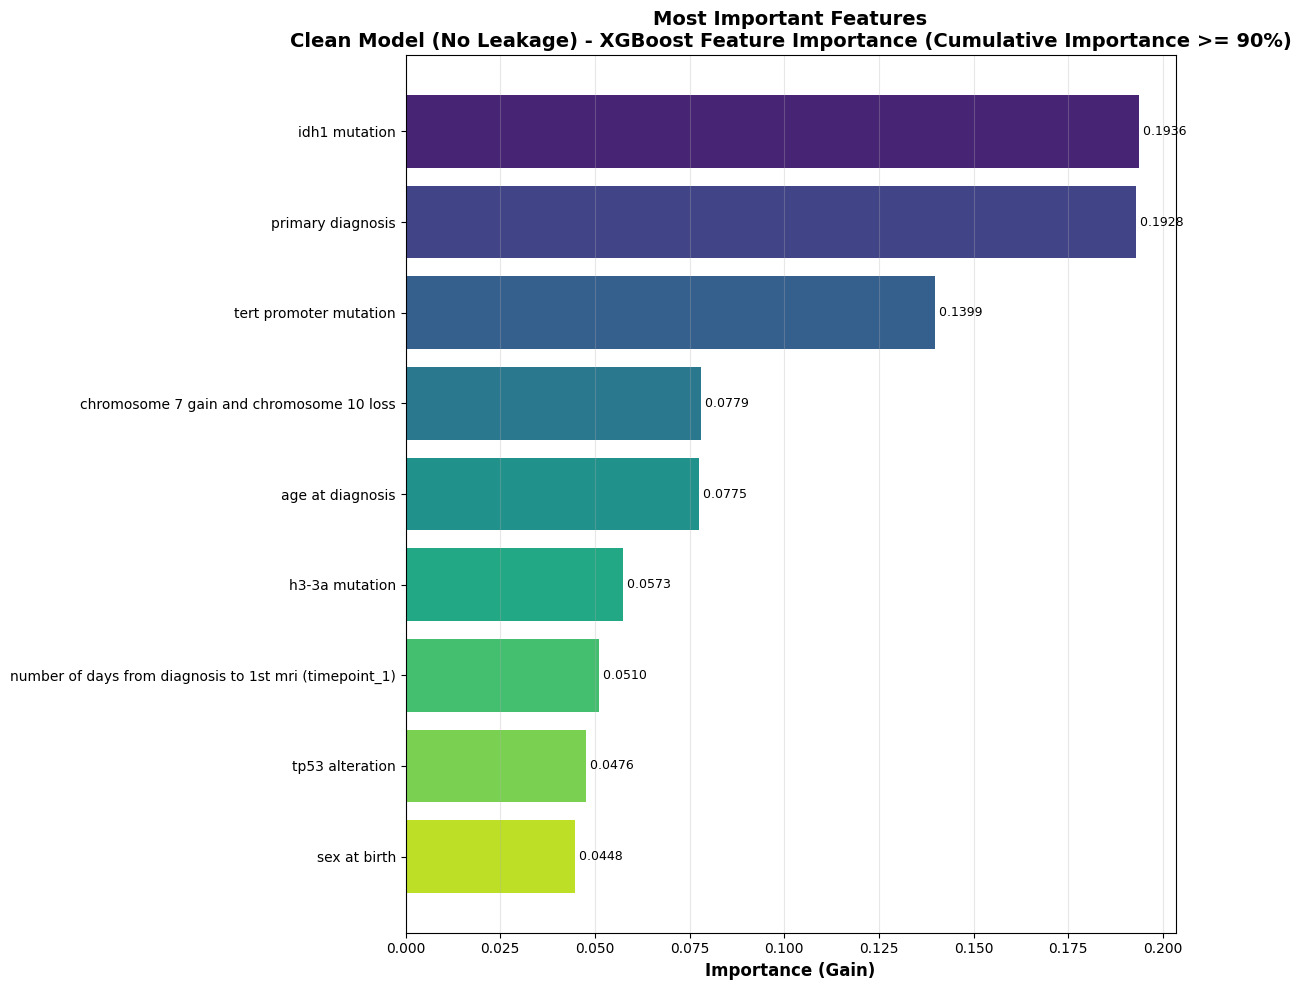


FINAL MODEL READY
Model name: Clean Model (No Leakage)
Trained on: 25 samples
ROC-AUC: 0.6735 ± 0.1113


✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
PIPELINE COMPLETE!
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅

Generated outputs:
  📊 hyperparameter_search_results.png
  📊 feature_importance_optimised.png

Returned objects:
  - model: Trained GliomaBinarySurvivalModel instance
  - random_search: RandomizedSearchCV results



In [ ]:
model_clean, search_clean = hyperparameter_search_and_train(
    X_clean, y_clean,
    importance_threshold=0.9,
    n_iter=100,
    model_name="Clean Model (No Leakage)"
)

### Compare Baseline vs Clean Model

In [ ]:
print("Model Comparison: Baseline vs Clean\n")

print(f"\n{'Metric':<15} {'Baseline (with leakage)':<28} {'Clean (no leakage)':<25}")
print("-"*70)

baseline_results = model.cv_results
clean_results = model_clean.cv_results

for metric in ['roc_auc', 'accuracy', 'f1']:
    baseline_mean = np.mean(baseline_results[f'test_{metric}'])
    baseline_std = np.std(baseline_results[f'test_{metric}'])
    clean_mean = np.mean(clean_results[f'test_{metric}'])
    clean_std = np.std(clean_results[f'test_{metric}'])

    print(f"{metric.upper():<15} {baseline_mean:.3f} ± {baseline_std:.3f} {' '*14} {clean_mean:.3f} ± {clean_std:.3f}")

Model Comparison: Baseline vs Clean


Metric          Baseline (with leakage)      Clean (no leakage)       
----------------------------------------------------------------------
ROC_AUC         0.730 ± 0.091                0.674 ± 0.111
ACCURACY        0.729 ± 0.092                0.670 ± 0.113
F1              0.729 ± 0.082                0.687 ± 0.094


### Clean Model Feature Importance

In [ ]:
feature_importance_clean = pd.DataFrame({
    'feature': X_clean.columns,
    'importance': model_clean.model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Features (Clean Model)")
print("-"*64)
for i, row in feature_importance_clean.head(15).iterrows():
    print(f"{row['feature']:<57} {row['importance']:.4f}")

Top 15 Features (Clean Model)
----------------------------------------------------------------
idh1 mutation                                             0.1936
primary diagnosis                                         0.1928
tert promoter mutation                                    0.1399
chromosome 7 gain and chromosome 10 loss                  0.0779
age at diagnosis                                          0.0775
h3-3a mutation                                            0.0573
number of days from diagnosis to 1st mri (timepoint_1)    0.0510
tp53 alteration                                           0.0476
sex at birth                                              0.0448
atrx mutation                                             0.0379
1p/19q                                                    0.0370
mgmt methylation                                          0.0315
grade of primary brain tumor                              0.0112
race                                                      0.

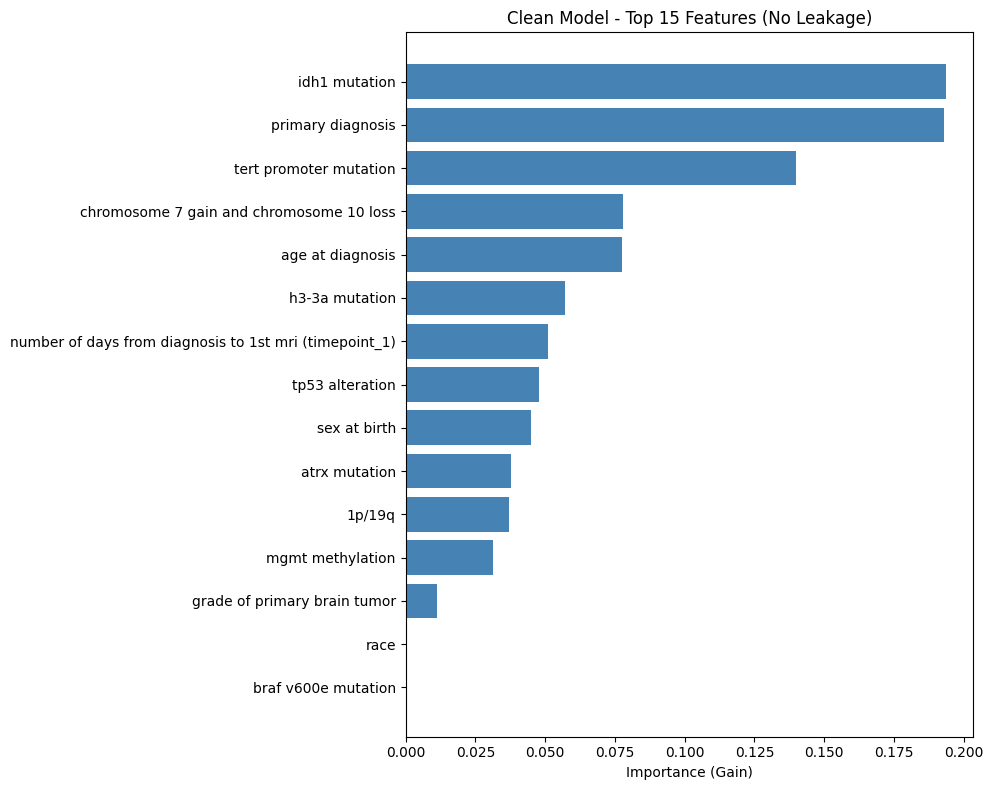

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 15
top_features = feature_importance_clean.head(top_n)

ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance (Gain)')
ax.set_title(f'Clean Model - Top {top_n} Features (No Leakage)')

plt.tight_layout()
plt.show()

### ROC Curve Comparison

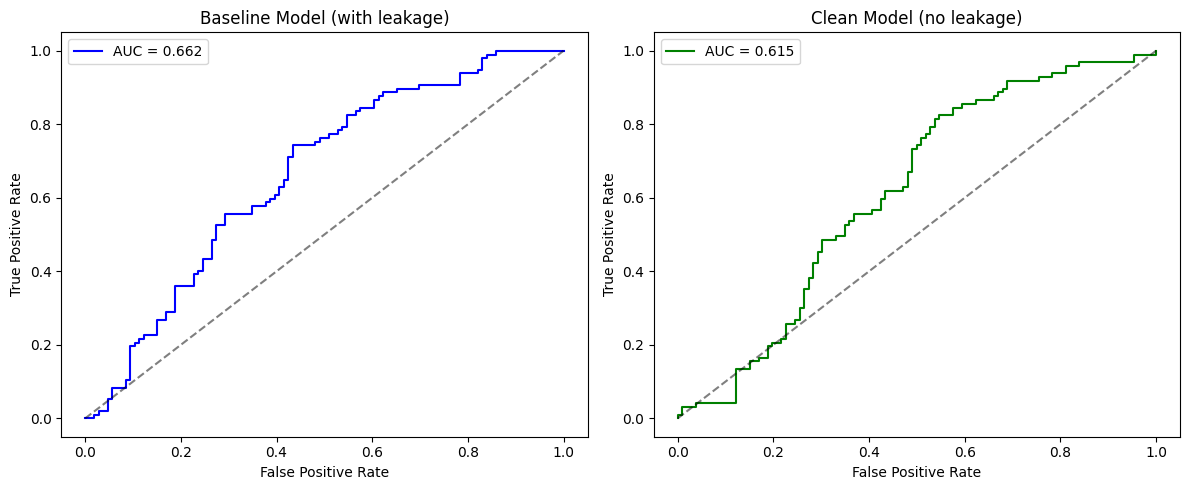


AUC change: 0.662 → 0.615 (4.7% decrease)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline model ROC
y_pred_baseline = cross_val_predict(model.model, X, y, cv=5, method='predict_proba')[:, 1]
fpr_base, tpr_base, _ = roc_curve(y, y_pred_baseline)
auc_base = auc(fpr_base, tpr_base)

axes[0].plot(fpr_base, tpr_base, 'b-', label=f'AUC = {auc_base:.3f}')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Baseline Model (with leakage)')
axes[0].legend()

# Clean model ROC
y_pred_clean = cross_val_predict(model_clean.model, X_clean, y_clean, cv=5, method='predict_proba')[:, 1]
fpr_clean, tpr_clean, _ = roc_curve(y_clean, y_pred_clean)
auc_clean = auc(fpr_clean, tpr_clean)

axes[1].plot(fpr_clean, tpr_clean, 'g-', label=f'AUC = {auc_clean:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Clean Model (no leakage)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nAUC change: {auc_base:.3f} → {auc_clean:.3f} ({(auc_base - auc_clean)*100:.1f}% decrease)")

### Confusion Matrix Comparison

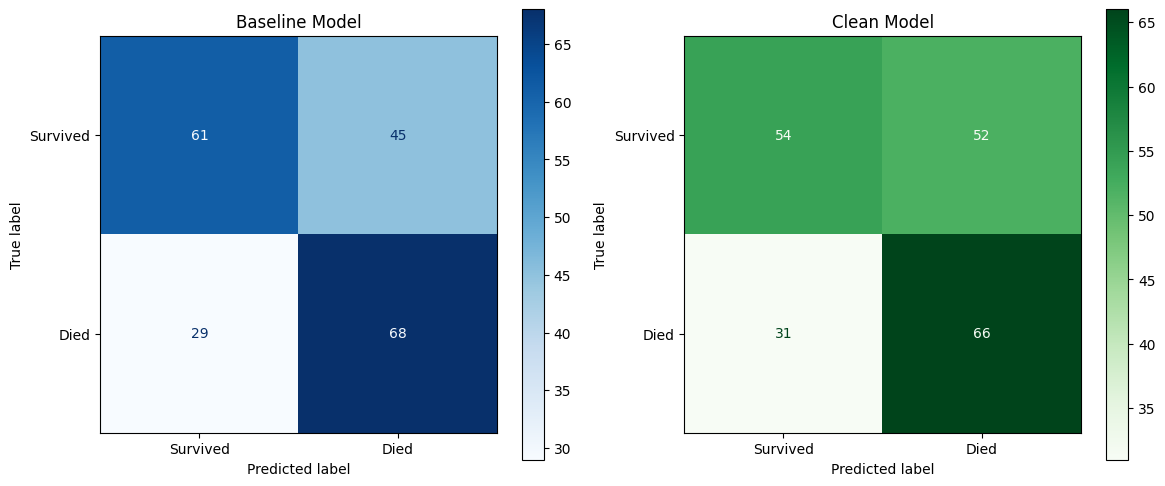

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline
y_pred_base_class = (y_pred_baseline > 0.5).astype(int)
cm_base = confusion_matrix(y, y_pred_base_class)
ConfusionMatrixDisplay(cm_base, display_labels=['Survived', 'Died']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Baseline Model')

# Clean
y_pred_clean_class = (y_pred_clean > 0.5).astype(int)
cm_clean = confusion_matrix(y_clean, y_pred_clean_class)
ConfusionMatrixDisplay(cm_clean, display_labels=['Survived', 'Died']).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Clean Model')

plt.tight_layout()
plt.show()

### Save Results

In [ ]:
import json

# Save clean model feature importance
output_dir = os.path.join(BASE_DATA_DIR, 'results')
os.makedirs(output_dir, exist_ok=True)

feature_importance_clean.to_csv(os.path.join(output_dir, 'feature_importance_clean.csv'), index=False)
print(f"Saved: feature_importance_clean.csv")

# Save comparison summary
results_summary = {
    'baseline': {
        'n_features': X.shape[1],
        'auc_mean': float(np.mean(baseline_results['test_roc_auc'])),
        'auc_std': float(np.std(baseline_results['test_roc_auc'])),
        'accuracy_mean': float(np.mean(baseline_results['test_accuracy'])),
        'f1_mean': float(np.mean(baseline_results['test_f1']))
    },
    'clean': {
        'n_features': X_clean.shape[1],
        'auc_mean': float(np.mean(clean_results['test_roc_auc'])),
        'auc_std': float(np.std(clean_results['test_roc_auc'])),
        'accuracy_mean': float(np.mean(clean_results['test_accuracy'])),
        'f1_mean': float(np.mean(clean_results['test_f1'])),
        'features_removed': leakage_features
    }
}

with open(os.path.join(output_dir, 'model_comparison.json'), 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"Saved: model_comparison.json")

Saved: feature_importance_clean.csv
Saved: model_comparison.json
